## Visualizing The Filters' Learning

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from imgaug import augmenters as iaa
import seaborn as sns
%matplotlib inline
device='cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
tfm=iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
    def __init__(self,folder):
        self.files=glob(folder)
    def __len__(self):
        return len(self.files)
    def __getitem__(self, item):
        f=self.files[item]
        im=tfm.augment_image(cv2.imread(f)[:,:,0])
        im=im[None]
        cl=f.split('@')[0]=='x'
        return torch.tensor(1-im/255).to(device).float(),torch.tensor([cl]).float().to(device)
data=XO(r'../data/Ch4/all/*')

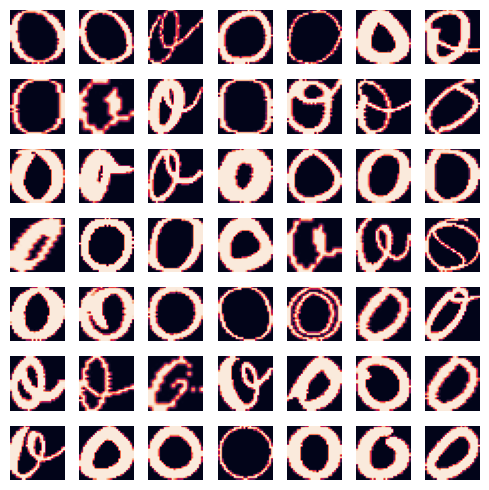

In [3]:
R,C=7,7
fig,ax=plt.subplots(R,C,figsize=(5,5))
for label_class,plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False);plot_cell.axis('off')
        ix=np.random.choice(1000)
        im,label=data[ix]
        plot_cell.imshow(im[0].cpu())
plt.tight_layout()

In [4]:
def get_model():
    model=nn.Sequential(
        nn.Conv2d(1,64,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200,256),
        nn.ReLU(),
        nn.Linear(256,1),
        nn.Sigmoid()
    ).to(device)
    loss_fn=nn.BCELoss()
    optimizer=Adam(model.parameters(),lr=1e-3)
    return model,loss_fn,optimizer

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    batch_loss=loss_fn(model(x),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x,y,model):
    model.eval()
    with torch.no_grad():
        predictiong=model(x)
    max_values,argmaxes=predictiong.max(-1)
    is_correct=argmaxes==y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x,y,model,loss_fn):
    model.eval()
    val_loss=loss_fn(model(x),y)
    return val_loss.item()

trn_dl=DataLoader(XO(r'../data/Ch4/all/*'),batch_size=32,drop_last=True)
model,loss_fn,optimizer=get_model()

In [5]:
summary(model,torch.zeros(1,28,28).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 1]             257
          Sigmoid-11                    [-1, 1]               0
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [6]:
for epoch in range(5):
    print(epoch)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

0
1
2
3
4


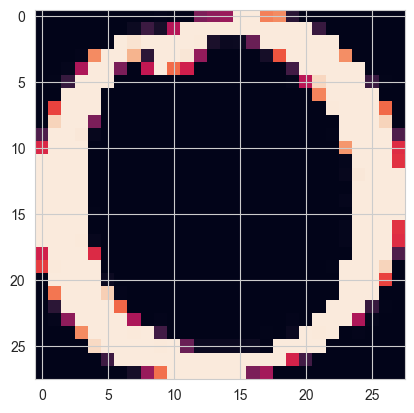

In [7]:
im, c = trn_dl.dataset[2]
plt.imshow(im[0].cpu())
plt.show()

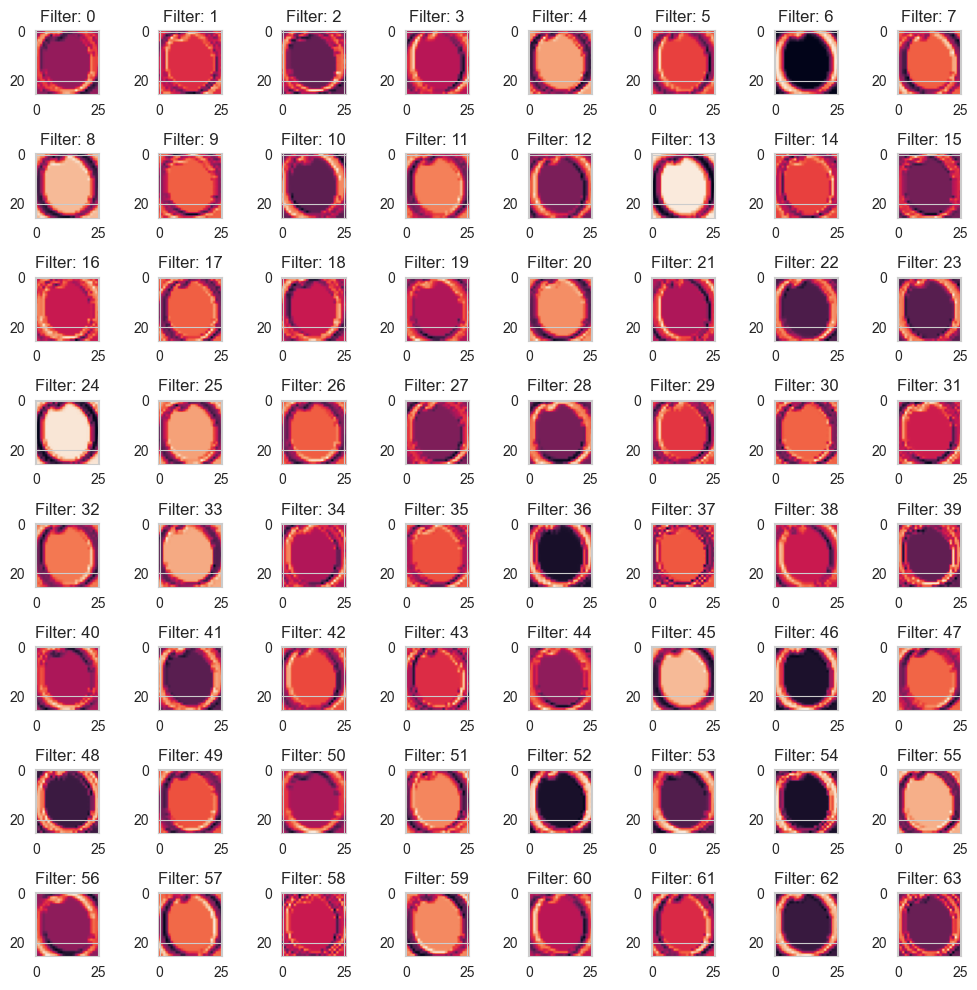

In [8]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

In [9]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3200, out_features=256, bias=True),
 ReLU(),
 Linear(in_features=256, out_features=1, bias=True),
 Sigmoid()]

In [10]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()

In [11]:
second_intermediate_output.shape

torch.Size([128, 11, 11])

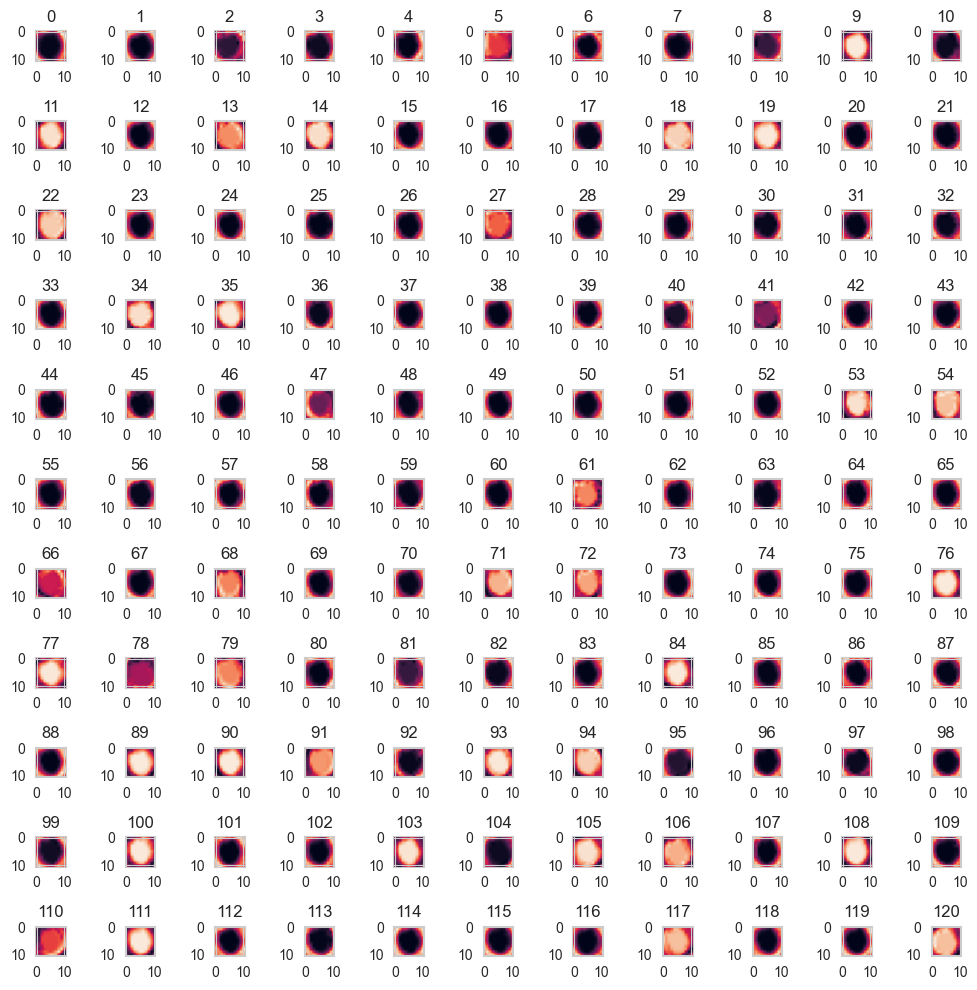

In [12]:
n = 11
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [13]:
im.shape

torch.Size([1, 28, 28])

In [14]:
x, y = next(iter(trn_dl))
x2 = x[y==0]
len(x2)

32

In [15]:
x2 = x2.view(-1,1,28,28)

In [16]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

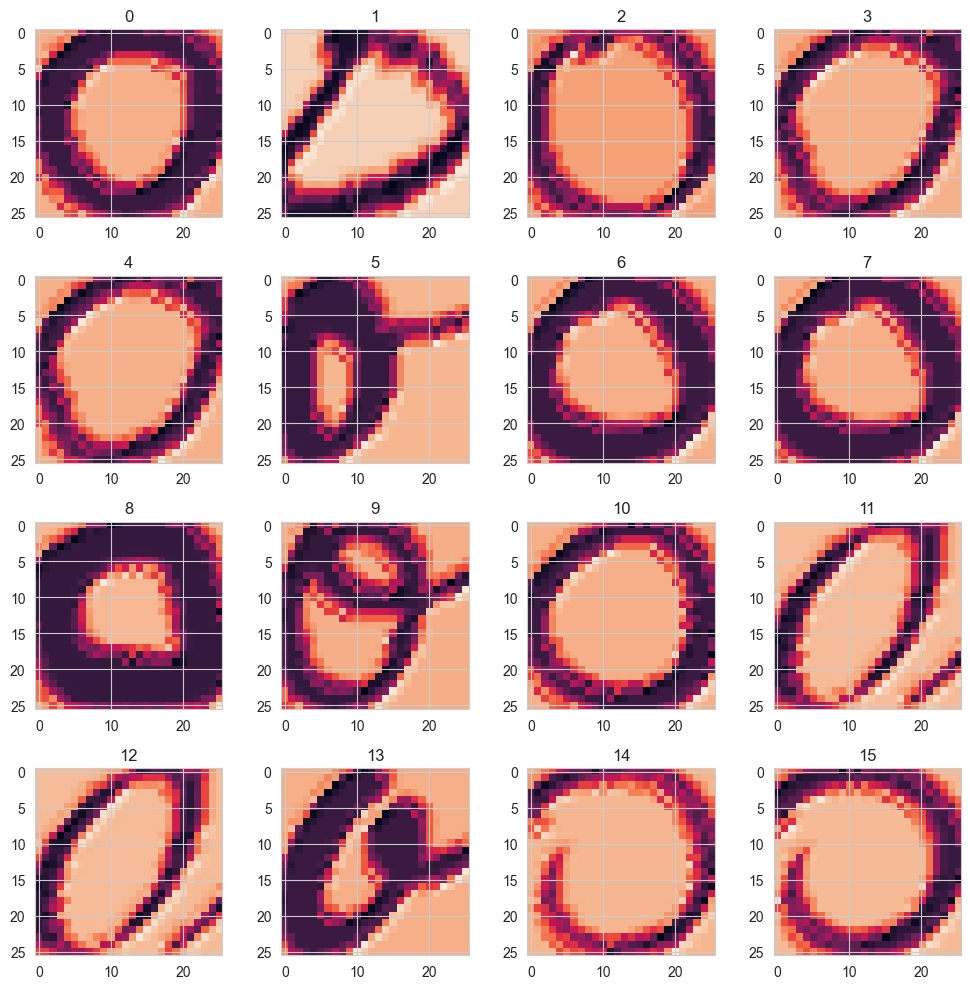

In [17]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix,4,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [18]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()

In [19]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(x2).detach()

In [20]:
second_intermediate_output.shape

torch.Size([32, 128, 11, 11])

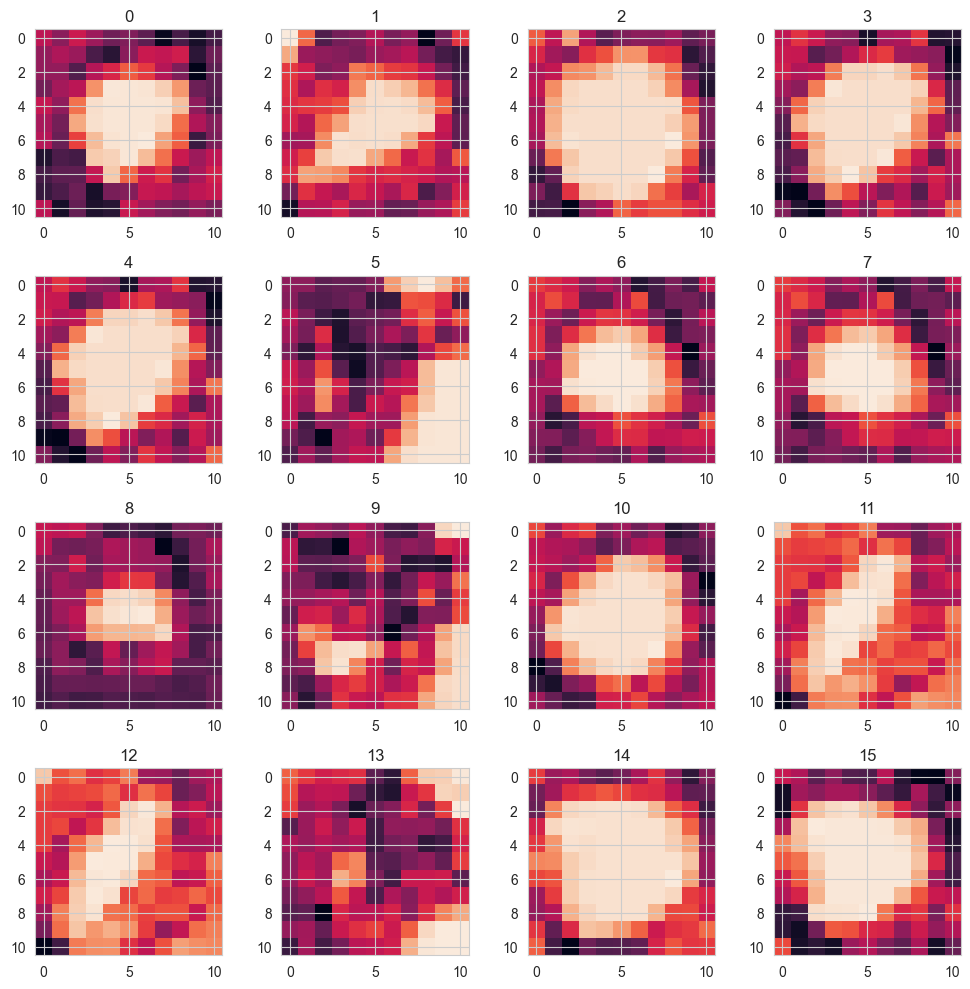

In [21]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix,34,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [22]:
len(XO(r'../data/Ch4/all/*'))

2498

In [23]:
custom_dl = DataLoader(XO(r'../data/Ch4/all/*'), batch_size=2498, drop_last=True)

In [24]:
x, y = next(iter(custom_dl))
x2 = x[y==0]
len(x2)

2498

In [25]:
x2 = x2.view(len(x2),1,28,28)

In [26]:
flatten_layer = nn.Sequential(*list(model.children())[:7])
flatten_layer_output = flatten_layer(x2).detach()

In [27]:
flatten_layer_output.shape

torch.Size([2498, 3200])

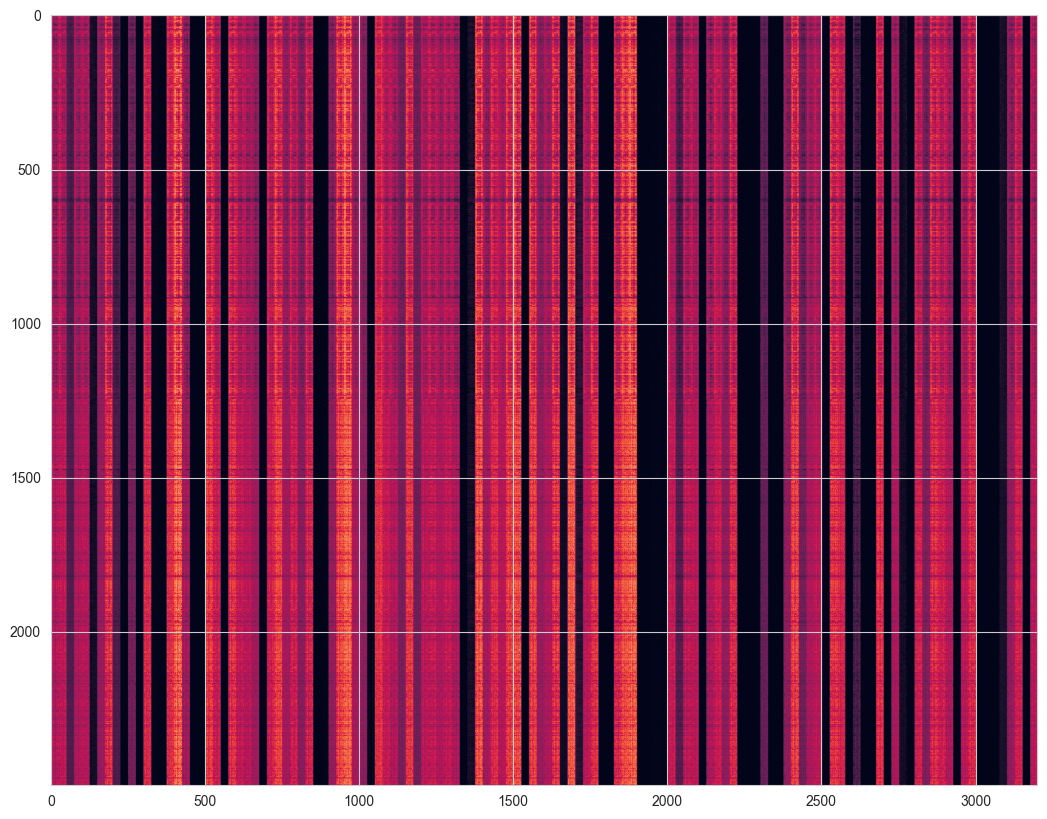

In [28]:
plt.figure(figsize=(100,10))
plt.imshow(flatten_layer_output.cpu())